In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import missingno as msno # visualization missing values (NA)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from catboost import CatBoostClassifier 

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import functional as F

from torchmetrics import Accuracy

from tqdm.autonotebook import tqdm
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
warnings.filterwarnings('ignore', 'FutureWarnings')
plt.style.use('dark_background')

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
titanic = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [3]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
# Перемещение колонки Survived в конец датафрейма
survived_pop = titanic.pop('Survived')
titanic['Survived'] = survived_pop
titanic.head(1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,0


<Axes: xlabel='Survived', ylabel='count'>

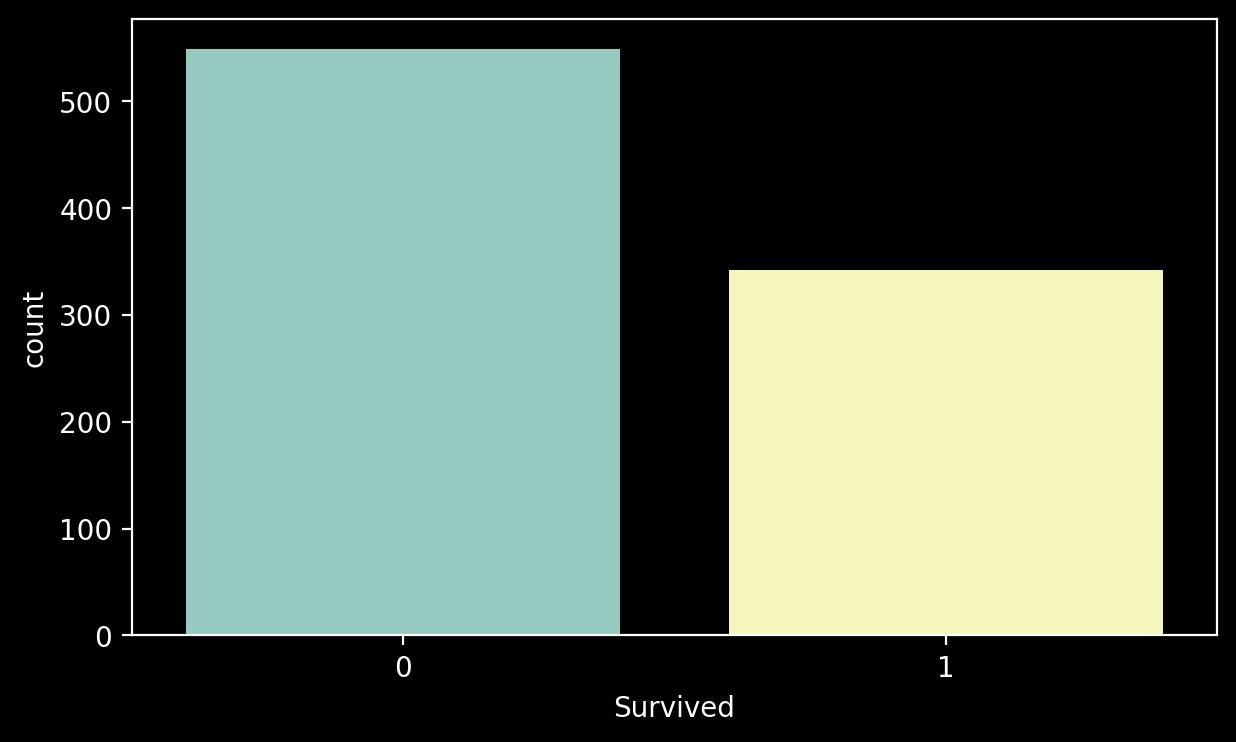

In [6]:
plt.figure(figsize=(7, 4), dpi=200)
sns.countplot(titanic, x='Survived')

<Axes: >

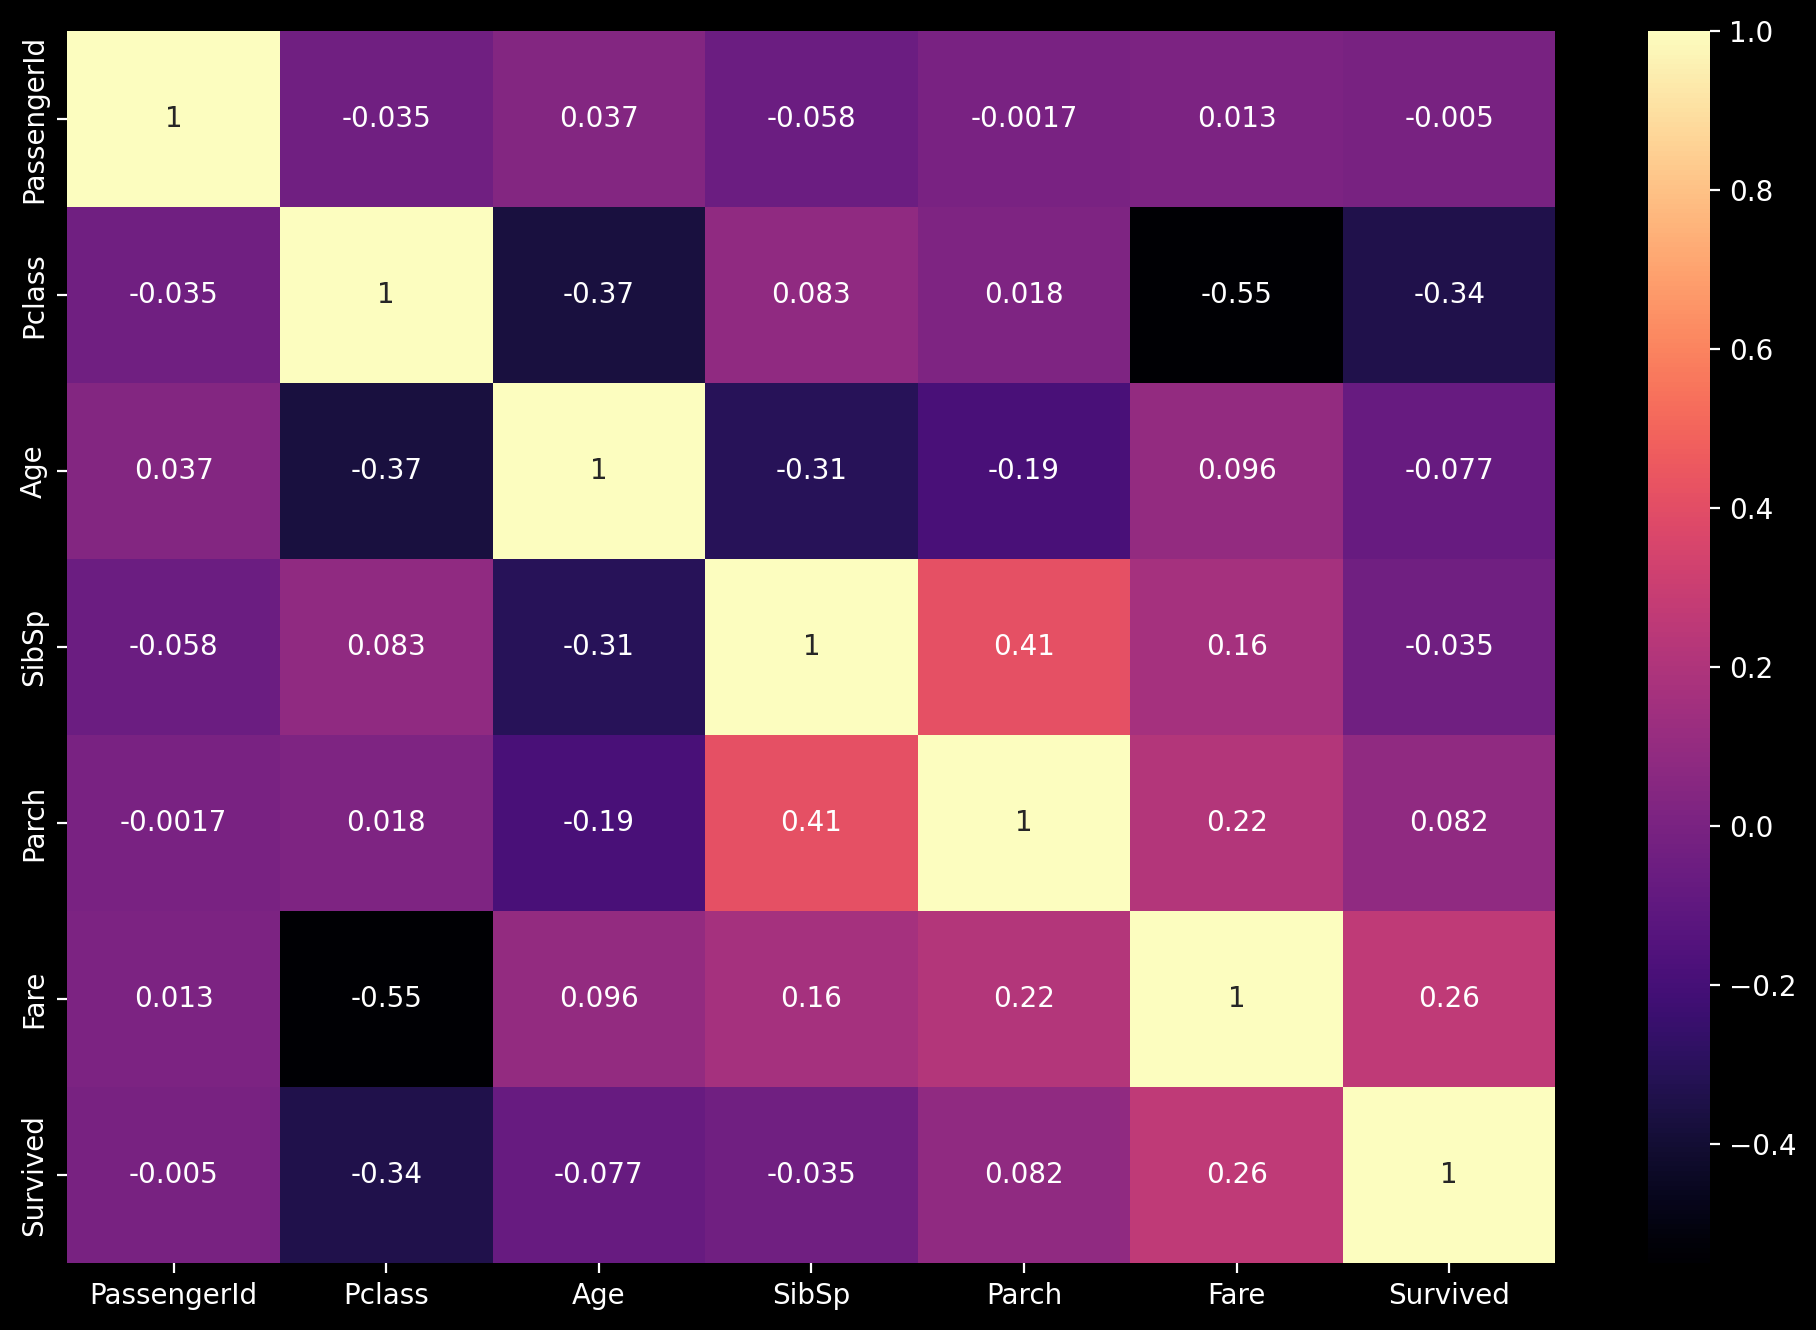

In [7]:
plt.figure(figsize=(12, 8), dpi=200)
sns.heatmap(titanic.corr(numeric_only=True), annot=True, cmap='magma')

## Работа с пропущенными значениями

<Axes: >

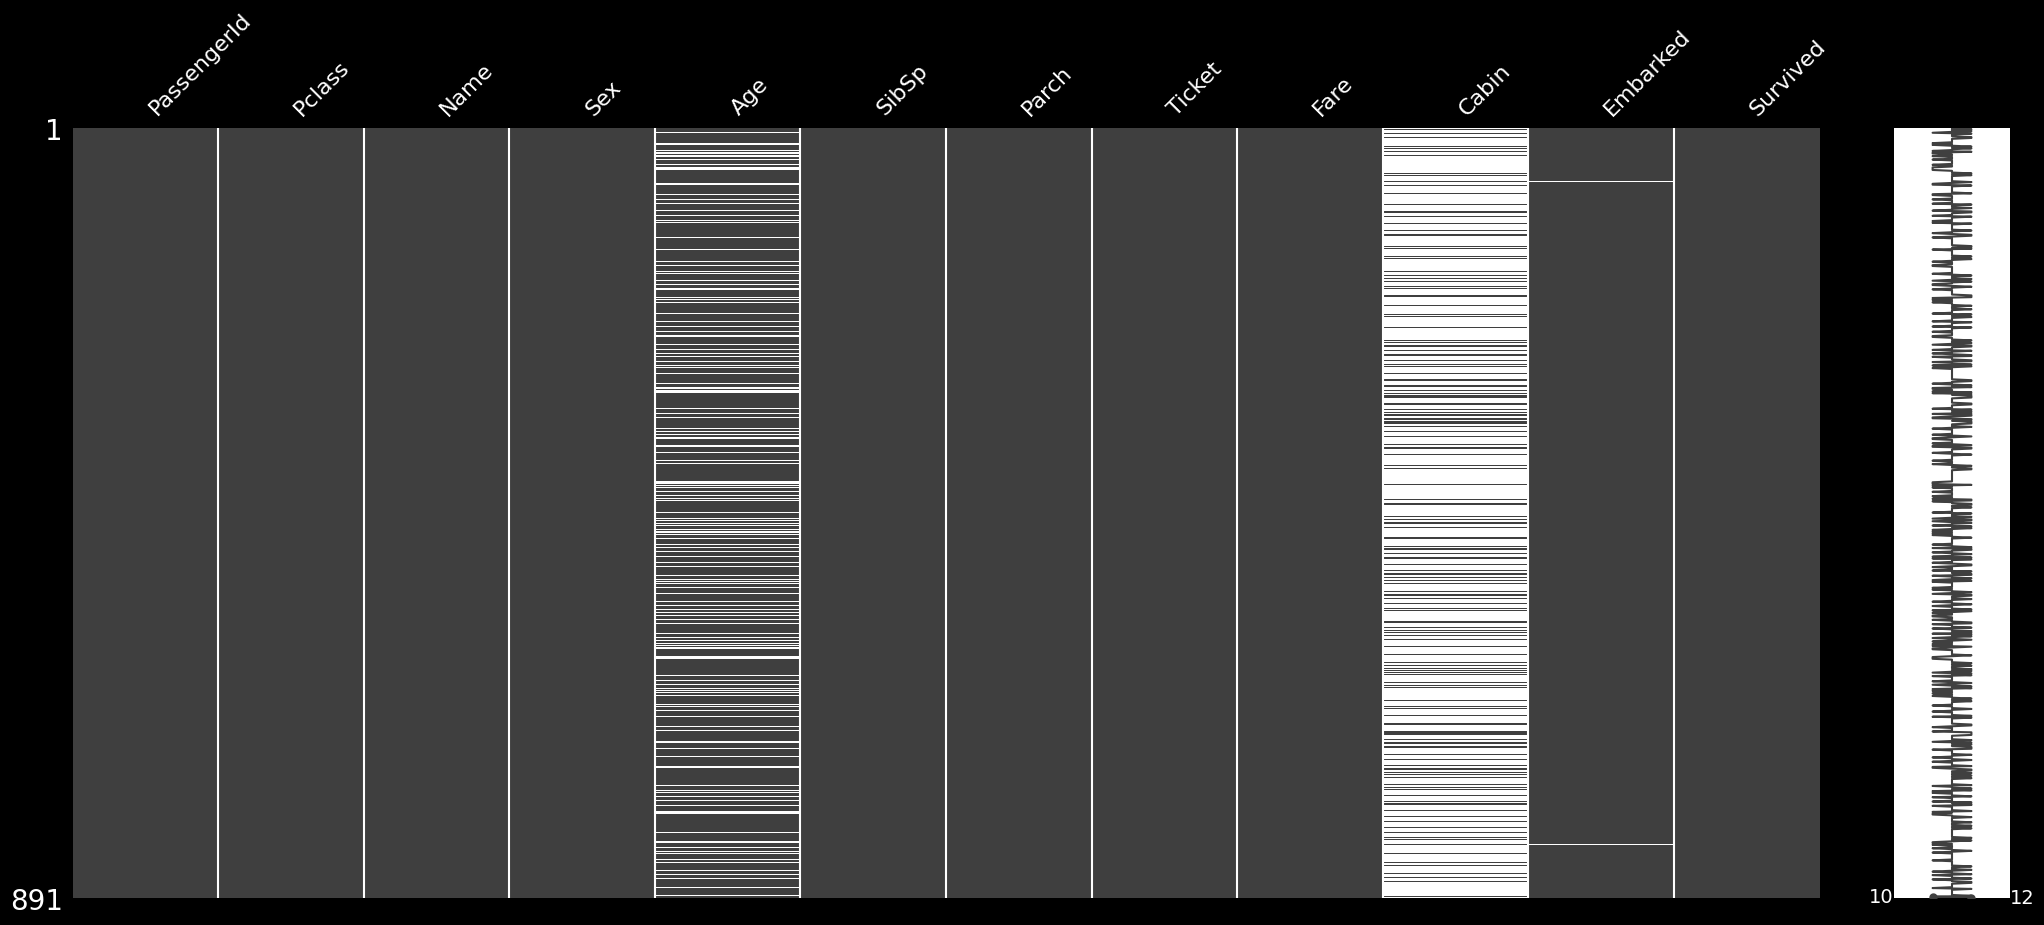

In [8]:
msno.matrix(titanic)

<Axes: >

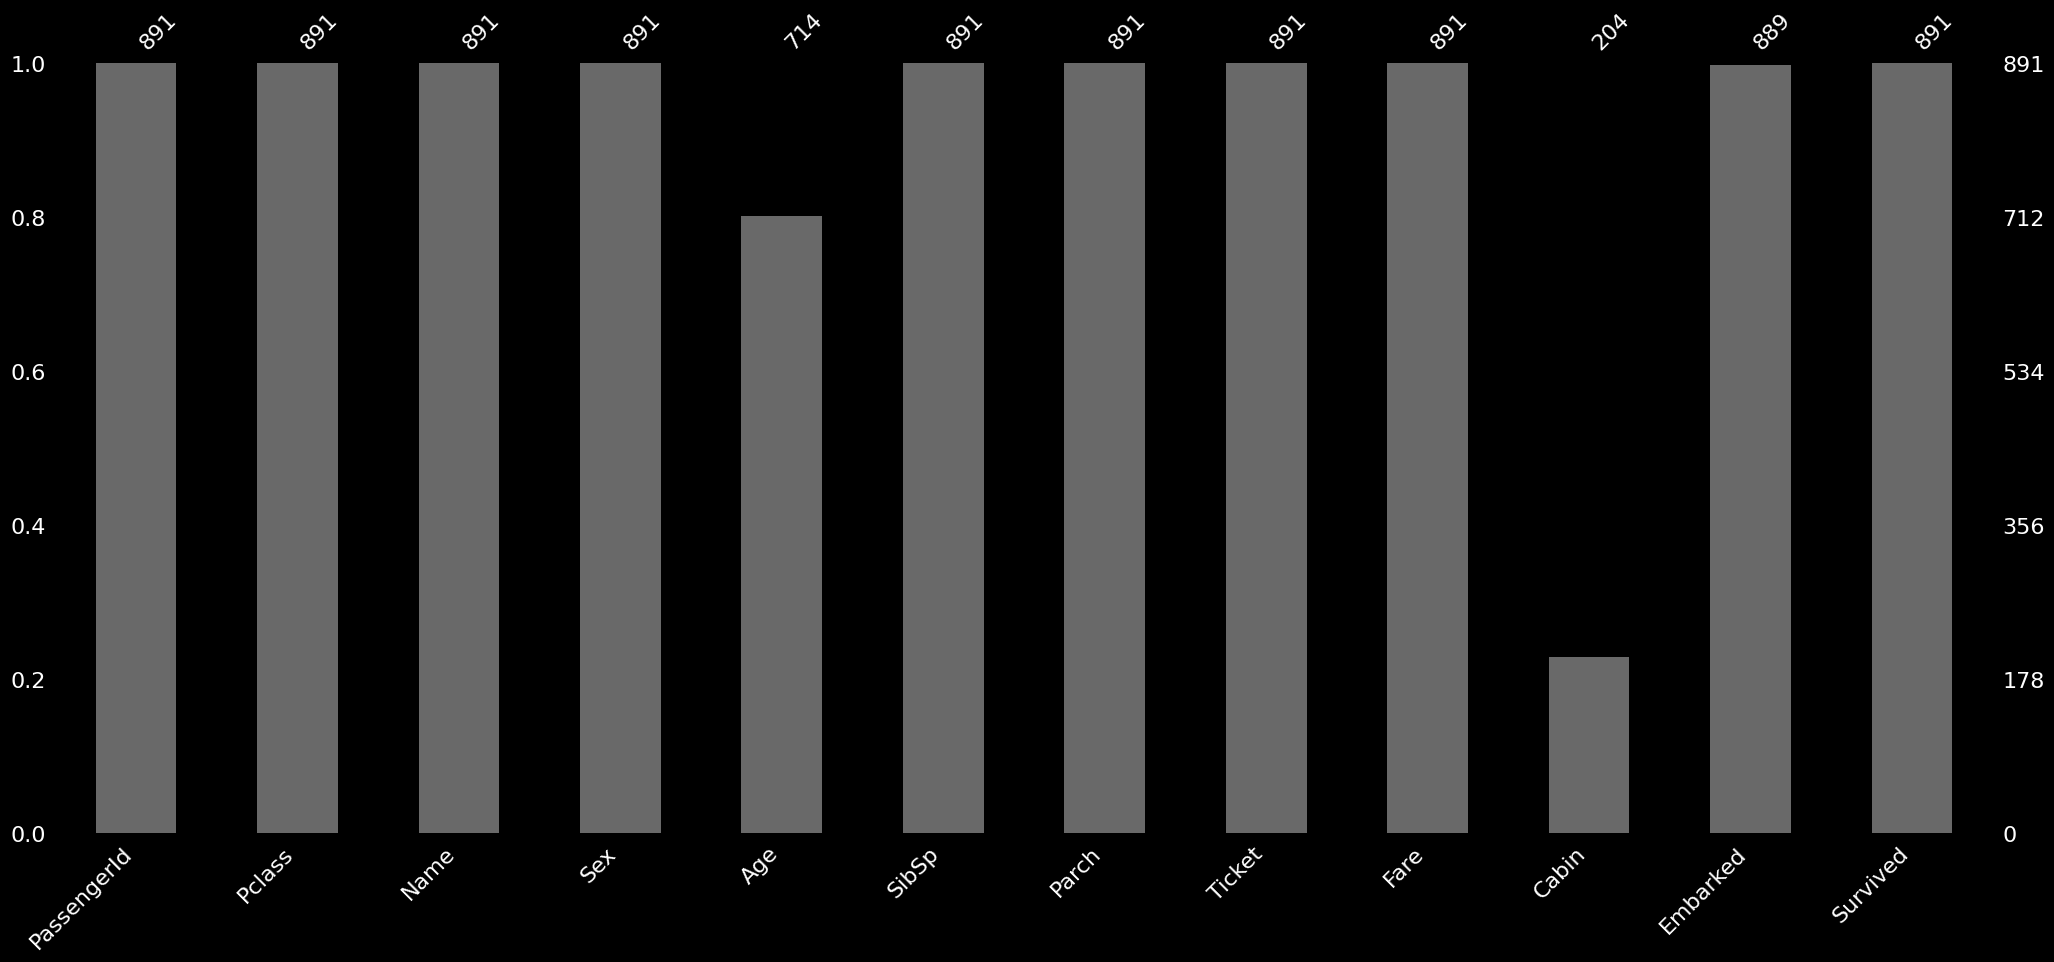

In [9]:
msno.bar(titanic)

<Axes: >

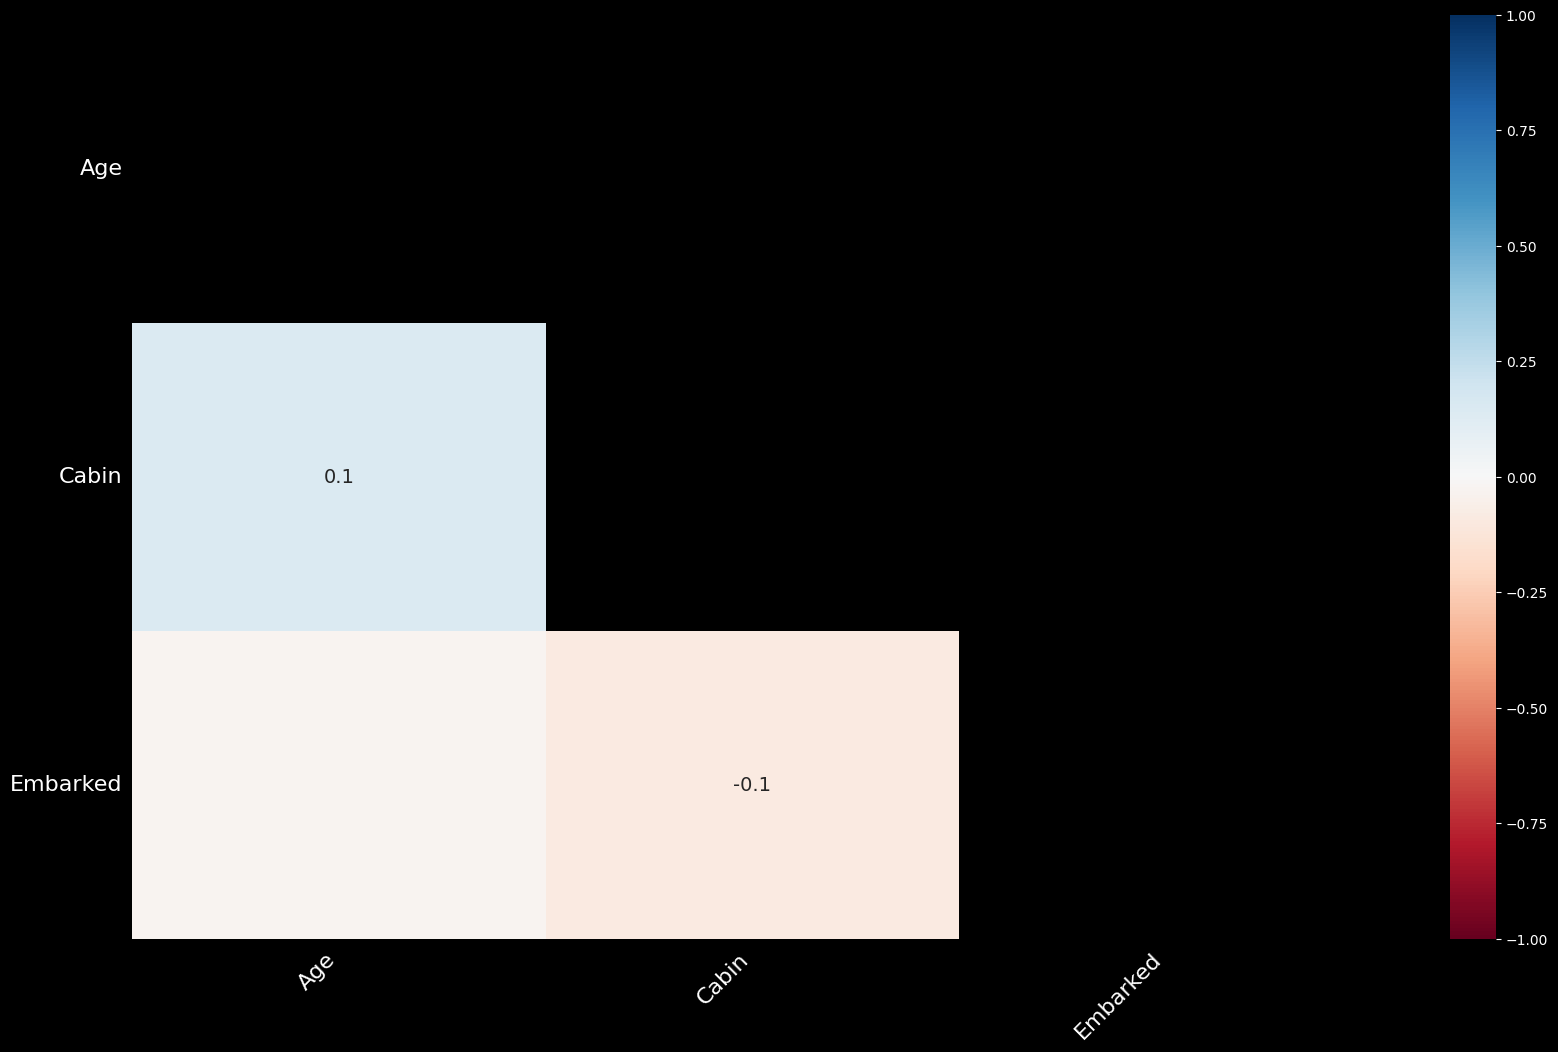

In [10]:
msno.heatmap(titanic)

<Axes: >

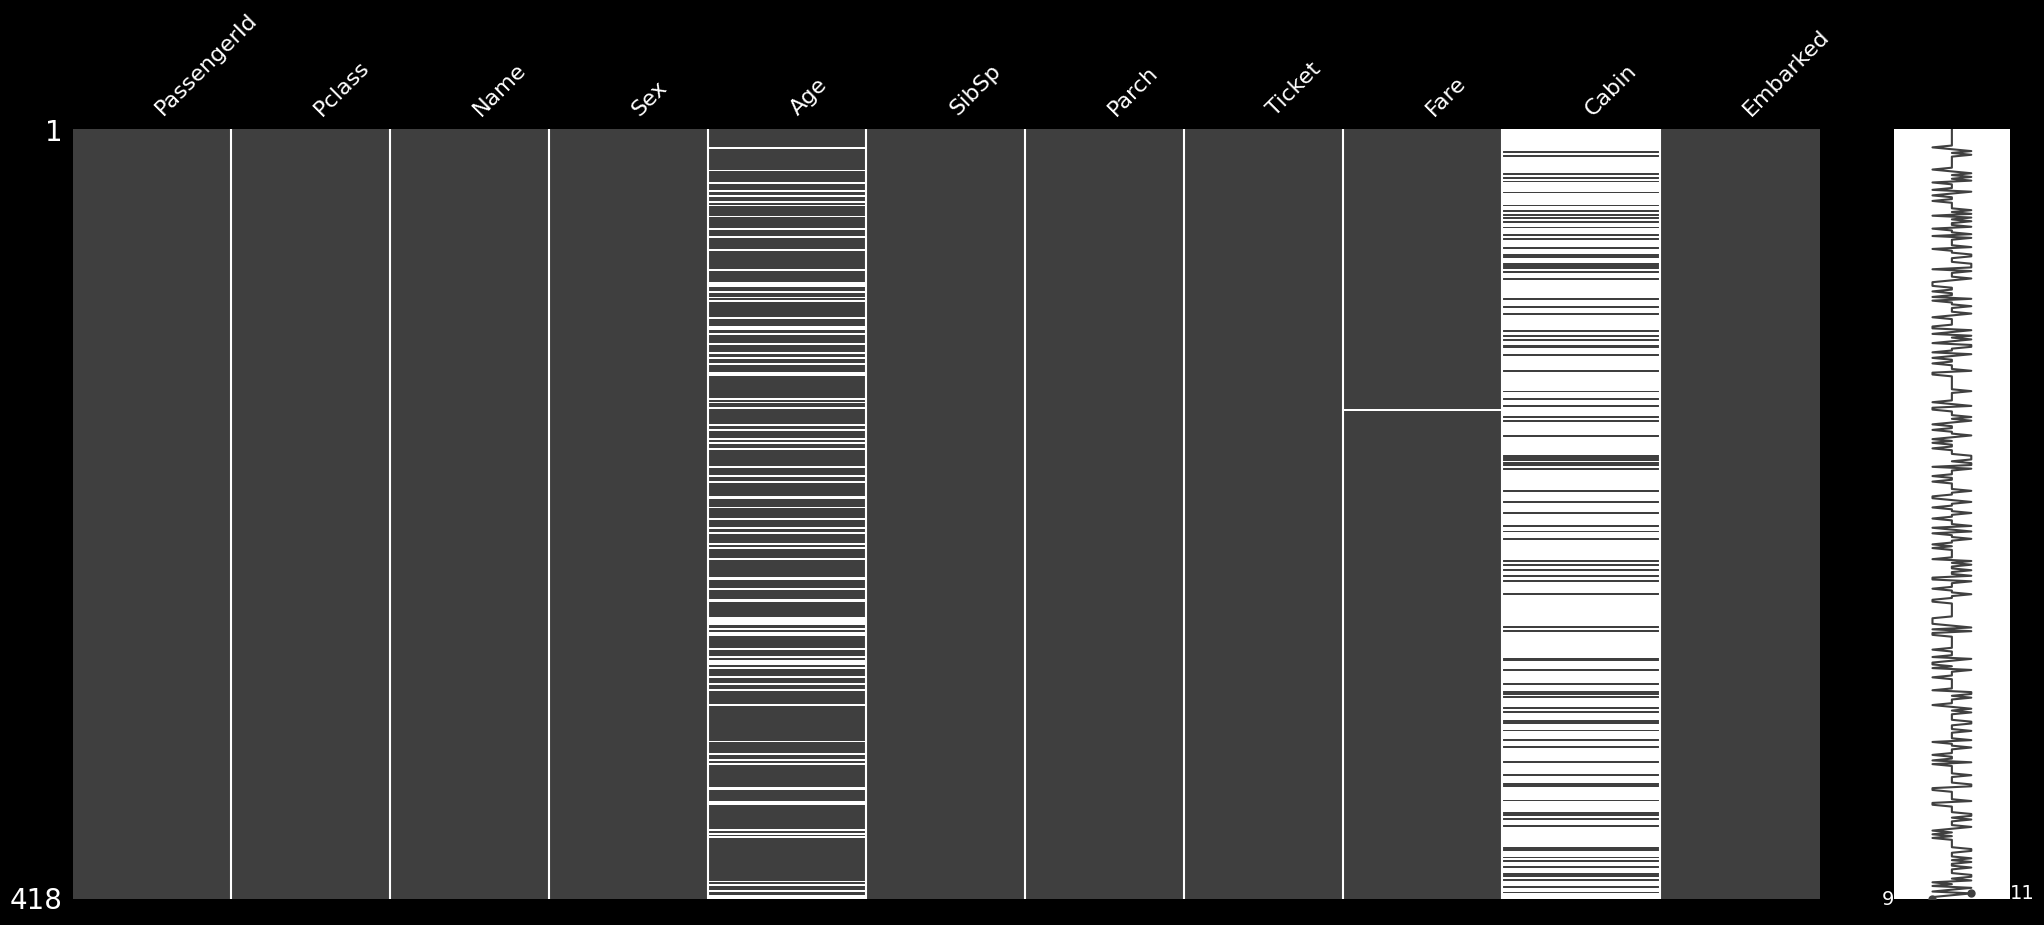

In [11]:
msno.matrix(test)

<Axes: >

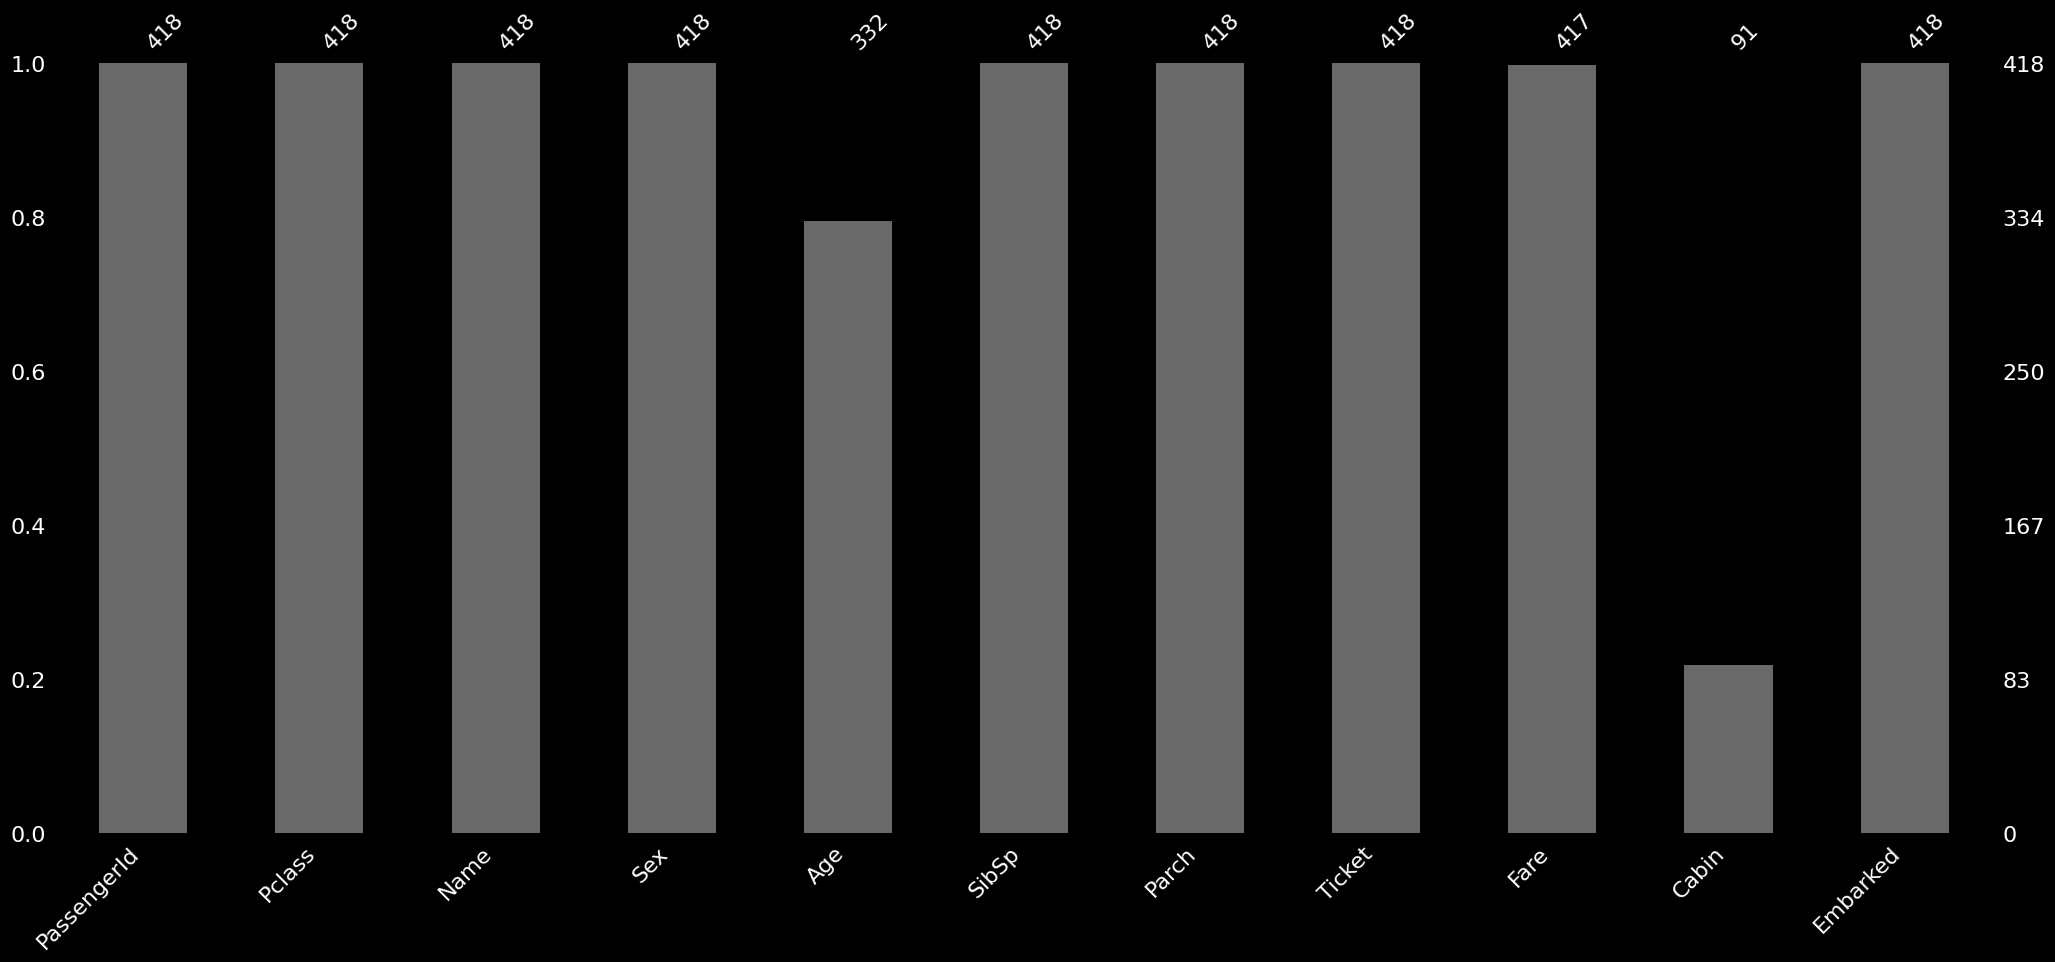

In [12]:
msno.bar(test)

<Axes: >

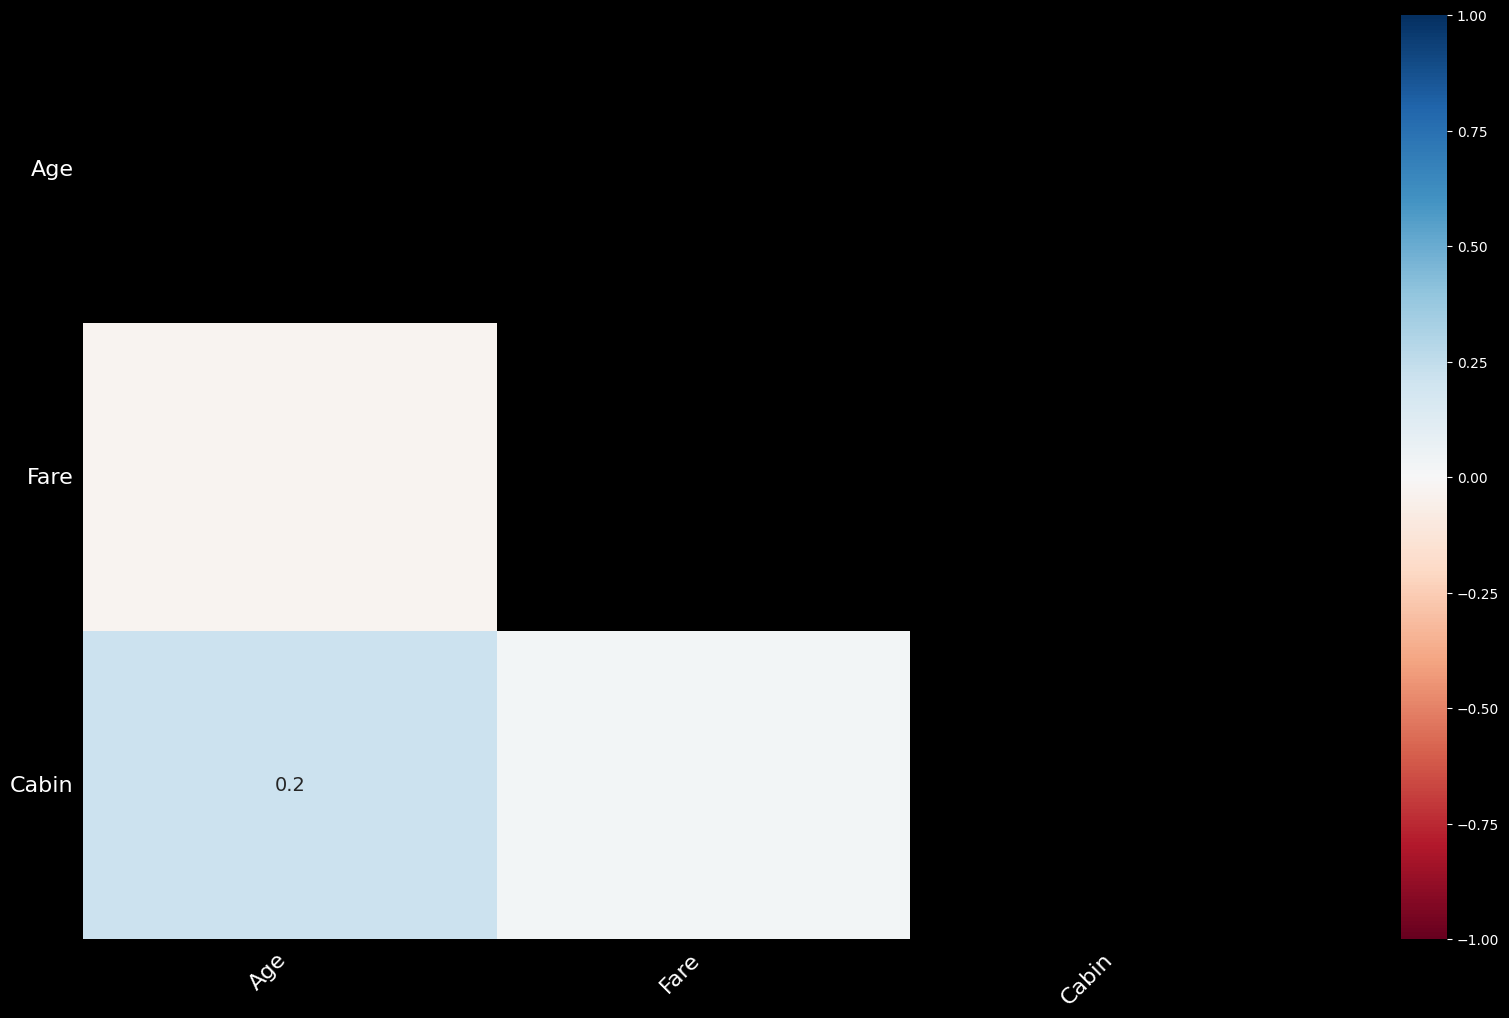

In [13]:
msno.heatmap(test)

In [14]:
titanic.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Survived         0
dtype: int64

In [15]:
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [16]:
# Объединение датафреймов для удобства
df = pd.concat([titanic.drop(columns='Survived'), test])

In [17]:
df.isna().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [18]:
df.drop(columns=['PassengerId', 'Cabin', 'Name', 'Ticket'], inplace=True)

In [19]:
df['Age'].describe()

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

In [20]:
df.corr(numeric_only=True)['Age'].sort_values(key=abs, ascending=False)

Age       1.000000
Pclass   -0.408106
SibSp    -0.243699
Fare      0.178740
Parch    -0.150917
Name: Age, dtype: float64

In [21]:
df.Pclass.unique()

array([3, 1, 2])

In [22]:
df.groupby('Pclass').Age.mean()

Pclass
1    39.159930
2    29.506705
3    24.816367
Name: Age, dtype: float64

In [23]:
# Заполняем пропущенные значения в столбце Age, основываясь на признаке Pclass
df['Age'] = df.Age.fillna(df.groupby('Pclass').Age.transform('mean'))

In [24]:
df.groupby('Parch').Fare.median()

Parch
0    10.50000
1    26.00000
2    31.38750
3    34.37500
4    27.90000
5    31.33125
6    46.90000
9    69.55000
Name: Fare, dtype: float64

In [25]:
df[df['Fare'].isna()]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
152,3,male,60.5,0,0,NaN,S


In [26]:
df['Fare'] = df.Fare.fillna(df.groupby('Parch').Fare.transform('mean'))

In [27]:
df['Embarked'].fillna(df['Embarked'].mode().item(), inplace=True)

/tmp/ipykernel_18/394009545.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Embarked'].fillna(df['Embarked'].mode().item(), inplace=True)


In [28]:
df.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

## Работа с признаками

In [29]:
df['Pclass'] = df['Pclass'].astype(object)

In [30]:
num_features = df.select_dtypes(exclude=object)
categorical_features = df.select_dtypes(include=object)

In [31]:
num_features.head()

,Age,SibSp,Parch,Fare
0,22.0,1,0,7.2500
1,38.0,1,0,71.2833
2,26.0,0,0,7.9250
3,35.0,1,0,53.1000
4,35.0,0,0,8.0500


In [32]:
categorical_features.head()

,Pclass,Sex,Embarked
0,3,male,S
1,1,female,C
2,3,female,S
3,1,female,S
4,3,male,S


In [33]:
def get_skew_kurt(df, col_name):
    return df[col_name].skew(), df[col_name].kurt()

In [34]:
# Проверка ассиметрии и эксцесса
for col in num_features:
    skew, kurtosis = get_skew_kurt(df, col)
    print(f'Для признака {col}: \n Ассиметрия: {skew};\n Эксцесс: {kurtosis}.')

Для признака Age: 
 Ассиметрия: 0.5543405224121433;
 Эксцесс: 0.7436970771316789.
Для признака SibSp: 
 Ассиметрия: 3.844220342922907;
 Эксцесс: 20.043251498181696.
Для признака Parch: 
 Ассиметрия: 3.6690782036511136;
 Эксцесс: 21.541078870706258.
Для признака Fare: 
 Ассиметрия: 4.369590994919865;
 Эксцесс: 27.05183710212493.


In [35]:
# Логорифмирование признаков
for col in num_features:
    if df[col].skew() > .5:
        df[col] = np.log1p(df[col])
    skew, kurtosis = get_skew_kurt(df, col)
    print(f'Для признака {col}: \n Ассиметрия: {skew};\n Эксцесс: {kurtosis}.')

Для признака Age: 
 Ассиметрия: -2.202354760811611;
 Эксцесс: 7.023162786493192.
Для признака SibSp: 
 Ассиметрия: 1.6368209762926682;
 Эксцесс: 2.491579626568578.
Для признака Parch: 
 Ассиметрия: 1.7897621054936539;
 Эксцесс: 2.421530342474208.
Для признака Fare: 
 Ассиметрия: 0.541274691632607;
 Эксцесс: 0.8554240949388485.


## Подготовка данных к обучению

In [36]:
X = df[:titanic.shape[0]]
y = titanic['Survived']

In [37]:
X.shape, y.shape

((891, 7), (891,))

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=77)

In [39]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((596, 7), (295, 7), (596,), (295,))

## CatBoostClassifier stock model

In [40]:
categorical_num = [X_train.columns.get_loc(col) for col in categorical_features]

In [41]:
cbc = CatBoostClassifier(cat_features=categorical_num, loss_function='Logloss')

In [42]:
cbc.fit(X_train, y_train)

Learning rate set to 0.00826
0:	learn: 0.6877089	total: 60ms	remaining: 60s
1:	learn: 0.6834311	total: 63.5ms	remaining: 31.7s
2:	learn: 0.6796286	total: 65.6ms	remaining: 21.8s
3:	learn: 0.6748089	total: 68.5ms	remaining: 17.1s
4:	learn: 0.6707192	total: 71.2ms	remaining: 14.2s
5:	learn: 0.6665978	total: 74.2ms	remaining: 12.3s
6:	learn: 0.6618933	total: 76.8ms	remaining: 10.9s
7:	learn: 0.6579590	total: 78.5ms	remaining: 9.73s
8:	learn: 0.6540557	total: 81.1ms	remaining: 8.93s
9:	learn: 0.6495125	total: 84.1ms	remaining: 8.33s
10:	learn: 0.6459478	total: 86.4ms	remaining: 7.77s
11:	learn: 0.6422058	total: 88.9ms	remaining: 7.32s
12:	learn: 0.6384360	total: 90.9ms	remaining: 6.9s
13:	learn: 0.6347751	total: 93.5ms	remaining: 6.58s
14:	learn: 0.6303398	total: 95.7ms	remaining: 6.28s
15:	learn: 0.6257943	total: 97.8ms	remaining: 6.02s
16:	learn: 0.6228014	total: 99.6ms	remaining: 5.76s
17:	learn: 0.6189286	total: 102ms	remaining: 5.55s
18:	learn: 0.6157730	total: 103ms	remaining: 5.34s


In [43]:
pred = cbc.predict(X_test)

In [44]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87       203
           1       0.68      0.82      0.74        92

    accuracy                           0.82       295
   macro avg       0.79      0.82      0.80       295
weighted avg       0.84      0.82      0.83       295



## Глубокое обучение Pytorch

### Подготовка данных

In [45]:
X_dummies = pd.get_dummies(X, drop_first=True, dtype=np.float32)

In [46]:
X_train, X_val, y_train, y_val = train_test_split(X_dummies, y, test_size=.33, random_state=77)

In [47]:
X_train.shape, X_val.shape

((596, 9), (295, 9))

In [48]:
# Перевод в тензоры
train_X = torch.from_numpy(X_train.values).to(torch.float32)
val_X = torch.from_numpy(X_val.values).type_as(train_X)

train_y = torch.from_numpy(y_train.values).to(torch.int32)
val_y = torch.from_numpy(y_val.values).type_as(train_y)

In [49]:
BATCH = 32

In [50]:
# Создание датасетов 
train_dataset = TensorDataset(train_X, train_y)
val_dataset = TensorDataset(val_X, val_y)
# Создание загрузчиков
train_loader = DataLoader(train_dataset, batch_size=BATCH)
val_loader = DataLoader(val_dataset, batch_size=BATCH)

### Создание модели нейронной сети

In [51]:
class TitanicModel(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.lin_linear1 = nn.Linear(in_features, 250)        
        self.lin_linear2 = nn.Linear(250, 150)
        self.lin_linear3 = nn.Linear(150, out_features)
        self.do1 = nn.Dropout(.8)
        self.do2 = nn.Dropout(.2)
        self.relu = F.relu
        self.sigmoid = torch.sigmoid
    
    def forward(self, x):
        x = self.lin_linear1(x)
        x = self.relu(x)
        
        x = self.lin_linear2(x)
        x = self.relu(x)
        x = self.do2(x)
        
        x = self.lin_linear3(x)
        
        return x

### Обучение модели TitanicModel

In [52]:
model = TitanicModel(train_X.shape[1], 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_function = nn.BCEWithLogitsLoss()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [53]:
EPOCHS = 150

loss_train = []
val_loss = []
total_loss = []
total_val_loss = []
acc_val = []

model = model.to(DEVICE)
accuracy = Accuracy(task='binary')

for epoch in tqdm(range(EPOCHS)):
    # Процесс обучения
    for iteration, (X_batch, y_batch) in enumerate(train_loader):
        # Перевод модели в режим обучения
        model.train()
        # Обнуляем градиенты у оптимизатора
        optimizer.zero_grad()
        # Пропускаем данные через модель        
        outputs = model(X_batch.to(DEVICE))
        outputs = outputs.view(-1)
        # Считаем лосс
        loss = loss_function(outputs, y_batch.to(torch.float32).to(DEVICE))
        # Делаем шаг в обратном направлении
        loss.backward()
        # Собираем лоссы
        loss_train.append(loss.detach().cpu().numpy().item())
        # Делаем шаг оптимизатора
        optimizer.step()
    # Собираем средний лосс
    total_loss.append(np.mean(loss_train))
    # Процесс валидации
    for iteration, (X_val, y_val) in enumerate(val_loader):
        # Перевод модели в режим валидации, тестирования
        model.eval()
        with torch.no_grad():
            outputs = model(X_val.to(DEVICE))
            outputs = outputs.view(-1)
            # Рассчитываем лосс
            loss = loss_function(outputs, y_val.to(torch.float32).to(DEVICE))
            # Собираем лосс
            val_loss.append(loss)
            # Считаем вероятности
            proba = torch.sigmoid(outputs)
            # Считаем метрику
            acc = accuracy(proba, y_val.to(DEVICE))
            acc_val.append(acc)
            
    # Собираем средний тестовый лосс
    total_val_loss.append(np.mean(val_loss))

  0%|          | 0/150 [00:00<?, ?it/s]

In [54]:
acc = np.mean(acc_val)
print(f'Accuracy: {acc:.2%}')

Accuracy: 78.45%


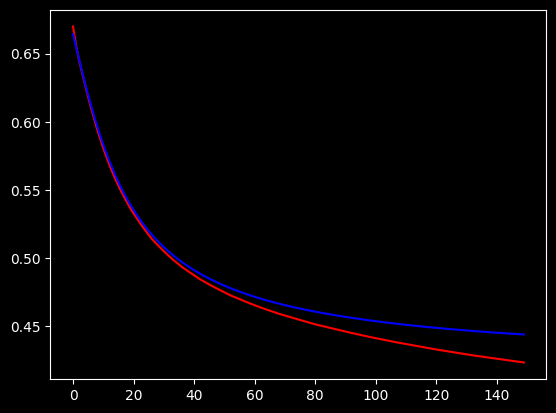

In [55]:
plt.plot(total_loss, color='red')
plt.plot(total_val_loss, color='blue')

## Тестовые данные

In [56]:
test_update = df[titanic.shape[0]:]

In [57]:
predict_test = cbc.predict(test_update)

In [58]:
result_df = pd.DataFrame(data={'PassengerId': test['PassengerId'].values,
                  'Survived': predict_test})

In [59]:
result_df.to_csv('cbc_stock_model.csv', index=False)